<a href="https://colab.research.google.com/github/aayushdangol16/Malicious-Url-Detection-Lstm/blob/main/minorproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malicious Url Detection-Lstm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data-Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from collections import Counter
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

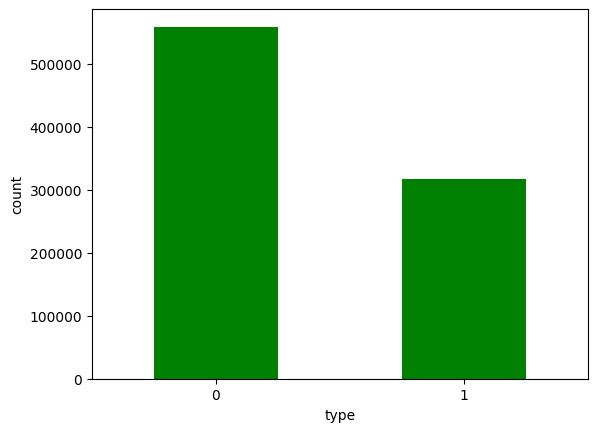

In [3]:
df=pd.read_csv('/content/drive/MyDrive/dataset.csv')
df.dropna(inplace=True)
type_counts=df['type'].value_counts()
type_counts.plot(kind='bar',rot=0,color='green')
plt.xlabel('type')
plt.ylabel('count')
plt.show()

In [ ]:
benign_entries = df[df['type'] == 0]
malicious_entries = df[df['type'] == 1]

In [ ]:
benign_entries = benign_entries.sample(n=len(malicious_entries), random_state=42)
df= pd.concat([benign_entries, malicious_entries])
df=df.sample(frac=1, random_state=42)
type_counts=df['type'].value_counts()
type_counts.plot(kind='bar',rot=0,color='green')
plt.xlabel('type')
plt.xlabel('count')
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/labelData.csv', index=False)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/labelData.csv')

In [ ]:
df['url']

0                                    https://www.google.com
1                                   https://www.youtube.com
2                                  https://www.facebook.com
3                                     https://www.baidu.com
4                                 https://www.wikipedia.org
                                ...                        
876227             http://digilander.libero.it/riccardog67/
876228                    https://pastebin.com/raw/Earh9hGr
876229      jacksonville.craigslist.org/fuo/2706610364.html
876230    http://torrentdn.com/bbs/s.php?bo_table=torren...
876231                pipl.com/directory/name/Heroux/Heroux
Name: url, Length: 876232, dtype: object

In [ ]:
df['type']

0         0
1         0
2         0
3         0
4         0
         ..
876227    1
876228    1
876229    0
876230    0
876231    0
Name: type, Length: 876232, dtype: int64

### Tokenization

In [4]:
url=list(df['url'])
Type=list(df['type'])

In [5]:
labels=np.array(Type)

In [6]:
def add_spaces_around_punctuation(input_list):
    translation_table = str.maketrans({key: f' {key} ' for key in string.punctuation})
    result_list = [s.translate(translation_table) for s in input_list]
    result_list = [s.split() for s in result_list]

    return result_list

output_list = add_spaces_around_punctuation(url)


output_string = ' '.join([' '.join(words) for words in output_list])


output_string = output_string.replace('[', '').replace(']', '')
#print(output_list)

#print(output_string)


In [ ]:
print(output_list[:40])

In [ ]:
print(output_string[:100])

In [7]:
alist=output_string.split(" ")

In [ ]:
alist[:40]

In [8]:
counts = Counter(alist)

In [ ]:
counts

In [9]:
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

In [ ]:
vocab_to_int

In [10]:
reviews_ints = []
for review in output_list:
    reviews_ints.append([vocab_to_int.get(word, 0) for word in review])

In [ ]:
reviews_ints[:3]

In [ ]:
Type[:3]

In [11]:
lengths = [len(sublist) for sublist in reviews_ints]

max_length = max(lengths)
min_length=min(lengths)
print(max_length)
print(min_length)


364
1


### Padding sequences

In [12]:
def pad_features(reviews_ints, seq_length):


    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [13]:
seq_length = 364
features = pad_features(reviews_ints, seq_length=seq_length)
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
print(features[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [ ]:
print(type(features))

<class 'numpy.ndarray'>


In [ ]:
features.shape

(876232, 364)

## Split Data

In [14]:
split_frac = 0.8
split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.1)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

train_x=train_x[:-85]
train_y=train_y[:-85]
val_x=val_x[:-24]
val_y=val_y[:-24]
test_x=test_x[:-23]
test_y=test_y[:-23]


print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(700900, 364) 
Validation set: 	(17500, 364) 
Test set: 		(157700, 364)


## DataLoaders and Batching

In [15]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size=100
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [ ]:
Features,Labels=next(iter(train_loader))

In [ ]:
Features.shape

In [ ]:
Labels.shape

In [16]:
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


## Defining Model

In [17]:
class malicious(nn.Module):
  def __init__(self,vocab_size,output_size,embedding_dim,hidden_dim,n_layers,drop_prob=0.5):
    super(malicious,self).__init__()
    self.output_size=output_size
    self.n_layers=n_layers
    self.hidden_dim=hidden_dim
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc=nn.Linear(hidden_dim,output_size)

  def forward(self,x,hidden):
    batch_size=x.size(0)
    x=x.long()
    embeds=self.embedding(x)
    lstm_out,hidden=self.lstm(embeds,hidden)
    lstm_out=lstm_out[:, -1, :] # getting the last time step output
    output=self.dropout(lstm_out)
    output=F.sigmoid(self.fc(output))
    return output,hidden

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

    return hidden

## Defining Hyperparameters

In [18]:
vocab_size=len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size=1
embedding_dim=400
hidden_dim=256
n_layers=2

model=malicious(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(model)

malicious(
  (embedding): Embedding(650291, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


## Training

In [19]:
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs=2
counter=0
print_every=1000
clip=5
total_train_losses,total_val_losses=[],[]
best_val_loss = float('inf')
patience = 7
early_stopping_counter = 0
if(train_on_gpu):
    model.cuda()
model.train()
for e in range(epochs):
  h=model.init_hidden(batch_size)
  train_losses=[]
  for Features,Labels in train_loader:
    counter+=1
    if(train_on_gpu):
      Features,Labels=Features.cuda(),Labels.cuda()
    h=tuple([each.data for each in h])
    model.zero_grad()
    output,h=model(Features,h)
    loss=criterion(output.squeeze(),Labels.float())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(),clip) # prevent the exploding gradient problem
    optimizer.step()
    train_losses.append(loss.item())

    if(counter % print_every==0):
      with torch.no_grad():
        val_h = model.init_hidden(batch_size)
        val_losses = []
        num_correct = 0
        model.eval()
        for Features,Labels in valid_loader:
          val_h = tuple([each.data for each in val_h])
          if(train_on_gpu):
            Features,Labels=Features.cuda(),Labels.cuda()
          output, val_h = model(Features,val_h)
          val_loss = criterion(output.squeeze(), Labels.float())
          val_losses.append(val_loss.item())
          pred = torch.round(output.squeeze())
          correct_tensor = pred.eq(Labels.float().view_as(pred))
          correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
          num_correct += np.sum(correct)
        accuracy = num_correct/len(valid_loader.dataset)
        val_loss_mean = np.mean(val_losses)
        model.train()
        total_train_losses.append(np.mean(train_losses))
        total_val_losses.append(val_loss_mean)
        print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(np.mean(train_losses)),
                  "Val Loss: {:.6f}".format(val_loss_mean),
              "Validation accuracy: {:.3f}".format(accuracy))
        train_losses=[]
        if val_loss_mean < best_val_loss:
          best_val_loss = val_loss_mean
          early_stopping_counter = 0
        else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
            print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(epochs))
            break
  if early_stopping_counter >= patience:
    break

Epoch: 1/2... Step: 1000... Loss: 0.091450... Val Loss: 0.110310 Validation accuracy: 0.966
Epoch: 1/2... Step: 2000... Loss: 0.047504... Val Loss: 0.089776 Validation accuracy: 0.970
Epoch: 1/2... Step: 3000... Loss: 0.036676... Val Loss: 0.073423 Validation accuracy: 0.975
Epoch: 1/2... Step: 4000... Loss: 0.033054... Val Loss: 0.063931 Validation accuracy: 0.979
Epoch: 1/2... Step: 5000... Loss: 0.030845... Val Loss: 0.062472 Validation accuracy: 0.978
Epoch: 1/2... Step: 6000... Loss: 0.029131... Val Loss: 0.061071 Validation accuracy: 0.979
Epoch: 1/2... Step: 7000... Loss: 0.028797... Val Loss: 0.057863 Validation accuracy: 0.981
Epoch: 2/2... Step: 8000... Loss: 0.017093... Val Loss: 0.060374 Validation accuracy: 0.981
Epoch: 2/2... Step: 9000... Loss: 0.016493... Val Loss: 0.060974 Validation accuracy: 0.982
Epoch: 2/2... Step: 10000... Loss: 0.016920... Val Loss: 0.057381 Validation accuracy: 0.982
Epoch: 2/2... Step: 11000... Loss: 0.016819... Val Loss: 0.055551 Validation ac

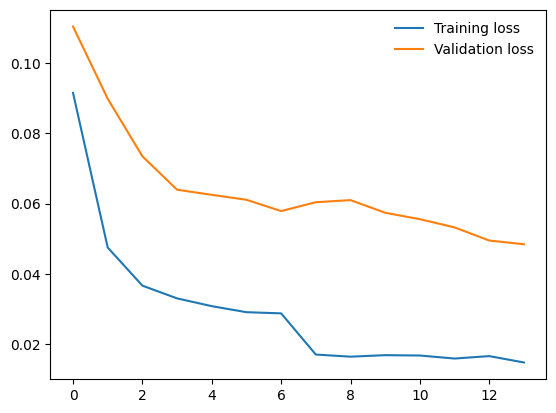

In [ ]:
plt.plot(total_train_losses, label='Training loss')
plt.plot(total_val_losses, label='Validation loss')
plt.legend(frameon=False)

## Checkpoint

In [ ]:
checkpoint = {'vocab_size': vocab_size,
              'output_size': model.output_size,
              'embedding_dim': embedding_dim,
              'hidden_dim':model.hidden_dim,
              'n_layers':model.n_layers,
              'batch_size':batch_size,
              'vocab_to_int':vocab_to_int,
              'state_dict': model.state_dict()}

In [ ]:
torch.save(checkpoint, '/content/drive/MyDrive/hacker.pth')

In [20]:
checkpoint = torch.load('/content/drive/MyDrive/dangol.pth')
vocab_size=checkpoint['vocab_size']
output_size=checkpoint['output_size']
embedding_dim=checkpoint['embedding_dim']
hidden_dim=checkpoint['hidden_dim']
n_layers=checkpoint['n_layers']
batch_size=checkpoint['batch_size']
vocab_to_int=checkpoint['vocab_to_int']
state_dict=checkpoint['state_dict']

In [21]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model.state_dict()

## Testing

In [ ]:
with torch.no_grad():
  model.cuda()
  test_losses = []
  num_correct = 0
  h = model.init_hidden(100)
  model.eval()
  for Features, Labels in test_loader:
      h = tuple([each.data for each in h])
      if(train_on_gpu):
          Features, Labels = Features.cuda(), Labels.cuda()
      output,h = model(Features,h)
      test_loss = criterion(output.squeeze(), Labels.float())
      test_losses.append(test_loss.item())
      pred = torch.round(output.squeeze())
      correct_tensor = pred.eq(Labels.float().view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      num_correct += np.sum(correct)

  print("Test loss: {:.3f}".format(np.mean(test_losses)))

  test_acc = num_correct/len(test_loader.dataset)
  print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.048
Test accuracy: 0.984


Test loss: 0.055
Test accuracy: 0.983


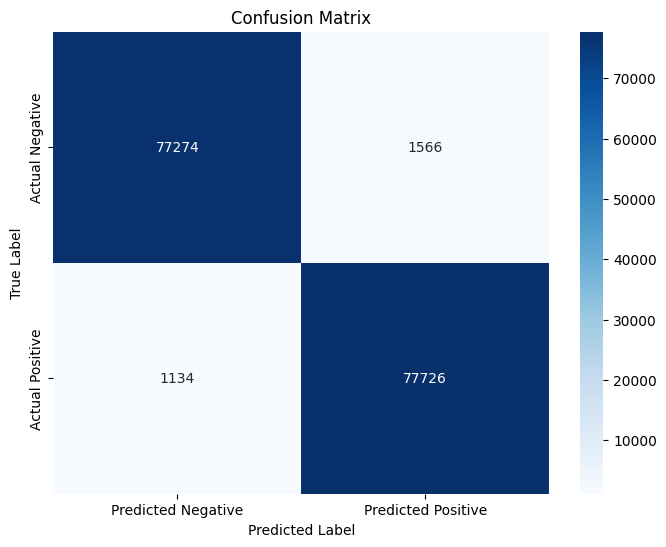

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


all_preds = []
all_labels = []

with torch.no_grad():
    model.cuda()
    test_losses = []
    num_correct = 0
    h = model.init_hidden(100)
    model.eval()
    for Features, Labels in test_loader:
        h = tuple([each.data for each in h])
        if train_on_gpu:
            Features, Labels = Features.cuda(), Labels.cuda()
        output, h = model(Features, h)
        test_loss = criterion(output.squeeze(), Labels.float())
        test_losses.append(test_loss.item())
        pred = torch.round(output.squeeze()).cpu().numpy()
        labels = Labels.cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(labels)
        correct_tensor = pred == labels
        num_correct += correct_tensor.sum()

    print("Test loss: {:.3f}".format(np.mean(test_losses)))

    test_acc = num_correct / len(test_loader.dataset)
    print("Test accuracy: {:.3f}".format(test_acc))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Inference


In [ ]:
def add_spaces_around_punctuation(input_list):
    translation_table = str.maketrans({key: f' {key} ' for key in string.punctuation})
    result_list = [s.translate(translation_table) for s in input_list]
    result_list = [s.split() for s in result_list]

    return result_list

def pad_features(reviews_ints, seq_length):
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    return features

def predict(feature_tensor):
  with torch.no_grad():
    model.cuda()
    h = model.init_hidden(feature_tensor.size(0))
    model.eval()
    h = tuple([each.data for each in h])
    if(train_on_gpu):
      feature_tensor= feature_tensor.cuda()
    output,h = model(feature_tensor,h)
    pred = torch.round(output.squeeze())
    print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))
    if(pred.item()==0):
      print("Not Malicious")
    else:
      print("Malicious")

url=[input("Enter Url: ")]
output_list = add_spaces_around_punctuation(url)

reviews_ints = []
for review in output_list:
    reviews_ints.append([vocab_to_int.get(word, 0) for word in review])

seq_length = 326
features = pad_features(reviews_ints, seq_length=seq_length)
assert len(features)==len(reviews_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."
feature_tensor=torch.from_numpy(features)
predict(feature_tensor)

Enter Url: www.facebook.com
Prediction value, pre-rounding: 0.173392
Not Malicious
